In [1]:
from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
# import chaospy as cp 
import seaborn
# seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
print(plt.style.available)
plt.style.use("seaborn-whitegrid")

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from scipy.integrate import odeint 
# from Utils.autograd_adjoint import odeint 

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


# Goal
Compare forward sensitivity using DA+RK4 implementation with adjoint sensitivity, demostrating that they indeed produce the same information. 

In [2]:
np.shape([[1, 0, 0],[1, 1, 1]])

(2, 3)

In [207]:
# Problem Data 
def dynamics(x, t, a, u=lambda t,x,a: 0, sqrt=pa.sqrt):
    dx = np.zeros_like(x, dtype=type(a))
    dx[0] = x[1]
    dx[1] = -a*x[1]*sqrt(1e-5+x[1]**2) + u(t,x,a)
    return dx 

def jacobian(x, a):
    return np.array([[0, 1, 0],[0, -2*a*pa.sqrt(1e-5+x[1]**2), -x[1]*pa.sqrt(1e-5+x[1]**2)],[0,0,0]])

tf = 3
t = np.linspace(0, tf, 300)

x0 = [8, -5.5] 
a = 0.05




Differential algebra solution

In [208]:
A = gdual_double(a, 'a', 2)
X0 = da.make(x0, ['x1','x2'], 2)

X = RK4(dynamics, X0, t, args=(A,))
names = ['x1','x2','a']
gradient = da.jacobian(X[-1], names)
stm = [da.jacobian(x, names) for x in X] # change in [x1, x2] wrt [x10, x20, a]
# hessian = [da.hessian(x, names) for x in X[-1]]
print(gradient)

[[ 1.          1.64383565 59.81008901]
 [ 0.          0.30024397 27.24714494]]


Adjoint solution

[[ 1.          1.6438346  59.8101759 ]
 [ 0.          0.30024363 27.24716346]]


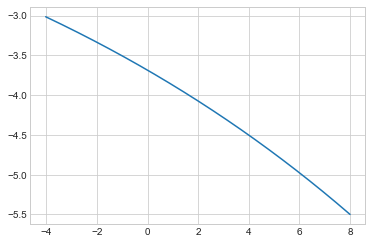

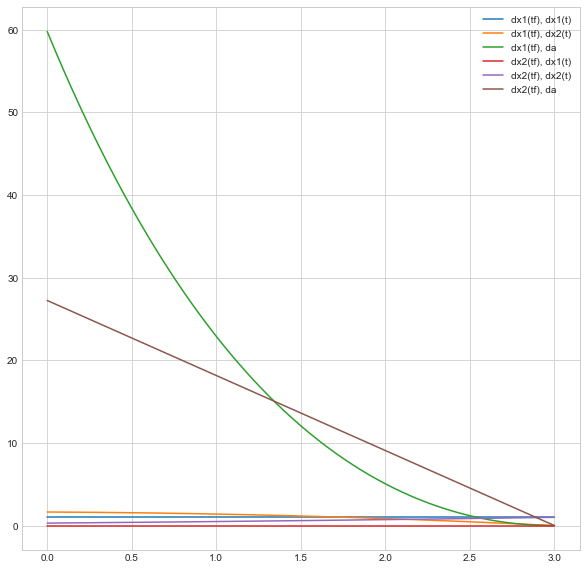

In [209]:
from scipy.interpolate import interp1d 

x = da.const(X, array=True)
x_interp = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
plt.plot(x.T[0],x.T[1])
def adjoint_dyn(p, t, X, J,):
    x = X(t)
    A = J(x)
    dp = -A.T.dot(p)
    return dp

J0 = []
P0 = np.eye(3)[:2]
plt.figure(figsize=(10,10))
for p0 in P0:
    Y = odeint(adjoint_dyn, p0, t[::-1], args=(x_interp, lambda x: jacobian(x,a),))
    plt.plot(t, Y[::-1])
    J0.append(Y[-1])
J0 = np.array(J0)
print(J0)
plt.legend(["dx1(tf), dx1(t)", "dx1(tf), dx2(t)", "dx1(tf), da","dx2(tf), dx1(t)", "dx2(tf), dx2(t)", "dx2(tf), da"])
plt.show()

In [210]:
print(np.max(np.abs(gradient-J0)))
assert np.allclose(gradient, J0, rtol=1e-1, atol=1e-2), "Forward and Adjoint Sensitivities do not match!"


8.689207265177856e-05


Determine the control costate with respect to the first state, i.e. $J = x_1$

(300, 2, 3)


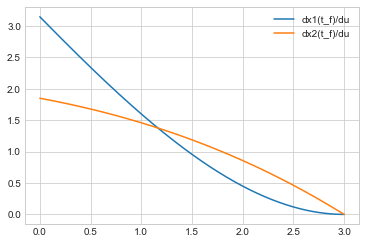

In [211]:
from scipy.integrate import cumtrapz
# This recovers the costates from STM 
dJdx = [[1, 0, 0],[0,1,0]]
stmi = [np.linalg.inv(np.append(st, [0,0,1]).reshape((3,3))) for st in stm]
stmf = np.append(stm[-1], [0,0,1]).reshape((3,3))
C = np.dot(dJdx, stmf)
p1 = np.array([np.dot(C, si) for si in stmi])
# plt.plot(t, p1[:,0])
# plt.plot(t, p1[:,1])

# p1 = [dx1/dx; dx2/dx]
print(p1.shape)
dfdu = [0, 1, 0]
# pu1 =  dx1(t_f)/du
pu1 =np.array( [np.trapz(x=t[i:], y=p1[i:,0,1]) for i in range(t.size)])  # Guaranteed to be correct
pu1_= -cumtrapz(x=t[::-1], y=np.squeeze(p1[::-1,0,1]), initial=0)[::-1] # so many weird flips required 
# Since integration is from tf to t, time and costate need to be reversed. Then, to plot against t, it must be reversed
# The negative sign is because pu1 is integrating forward, while pu1_ is integrating backward 
pu2 = np.array([np.trapz(x=t[i:], y=p1[i:,1,1]) for i in range(t.size)])
plt.figure()
plt.plot(t, pu1, label="dx1(t_f)/du")
plt.plot(t, pu2, label="dx2(t_f)/du")
# plt.plot(t, pu1[0] - cumtrapz(x=t, y=pu2, initial=0))
plt.legend()
# plt.plot(t, pu1_,'o')
plt.show()

Any "terminal point" controller$^1$, takes the form 
\begin{align}
\Delta u =  \frac{\Delta J}{\lambda_u} =\frac{\lambda_x^T\Delta x}{\lambda_u} 
\end{align}
where $\lambda_q(t) \triangleq \frac{\partial J(x(t_f))}{\partial x(t_f)}\frac{\partial x(t_f)}{\partial q(t)} $. This can also be written in terms of the first order state transtion matrix 
\begin{align}
\lambda_x(t) = \frac{\partial J(x_f)}{\partial x_f}\Phi(t_f)\Phi^{-1}(t) \\
\Delta u =  \frac{\Delta x^T\left( \frac{\partial J}{\partial x}\Phi(t_f)\Phi^{-1}(t)\right)}{\lambda_u} 
\end{align}

1. i.e., one that seeks to drive the variation in the Mayer objective to zero despite small variations in state/parameters from the nominal

In [212]:
# Use any reference traj, select a nearby initial condition, and use the TPC to drive it to the same terminal condition at tf. 
from scipy.interpolate import interp1d 

class TPC:
    def __init__(self, t, x, u, a, px, pu):
        self.t = t
        self.x = interp1d(t, x, axis=0, bounds_error=False, fill_value=(x[0],x[-1]))
        self.u = interp1d(t, u, axis=0, bounds_error=False, fill_value=(u[0],u[-1]))
        self.pu = interp1d(t, pu, axis=0, bounds_error=False, fill_value=(pu[0],pu[-1]))
        self.px = interp1d(t, px, axis=0, bounds_error=False, fill_value=(px[0],px[-1]))
        self.a = a

        
    def __call__(self, t, x, a):
        
        px = self.px(t)
        pu = self.pu(t)
        if np.abs(pu) < 1e-3:
            pu = np.sign(pu)*1e-3
        if np.ndim(x) == 1 and np.ndim(a) == 0:
            
            dx = np.append(x-self.x(t), a-self.a)
            return self.u(t) - np.dot(dx, px)/pu
        
        else:
            if np.ndim(x) > 1:
                dx = x-self.x(t)[:,None]
            else:
                dx = x-self.x(t)
                
            da = a - self.a  # doesn't matter if a is an array or scalar 
            return self.u(t) - (px[-1]*da + np.dot(px[:-1], dx))/pu
 


In [244]:
def Obj(xf):
#     return xf[0]**2 + xf[1]**2  # match the manifold
#     return xf[0]  # match position
#     return xf[1]  # match velocity 
    return xf[0]*xf[1]

Xf = da.make([x[-1,0],x[-1,1], a], ['x1','x2','a'], 1)
dJdx = da.gradient(Obj(Xf), ['x1','x2','a'])
C = np.dot(dJdx, stmf)
px = np.array([np.dot(C, si) for si in stmi])
pu = np.array( [np.trapz(x=t[i:], y=px[i:, 1]) for i in range(t.size)])
        
controller = TPC(t, x, np.zeros_like(t), a, 1*px, pu)  # The costates passed here determine the objective 
sat_controller = lambda t,x,a: np.clip(controller(t,x,a), -100, 100)

C:\Users\cdnoyes\AppData\Local\Continuum\anaconda3\envs\edl\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


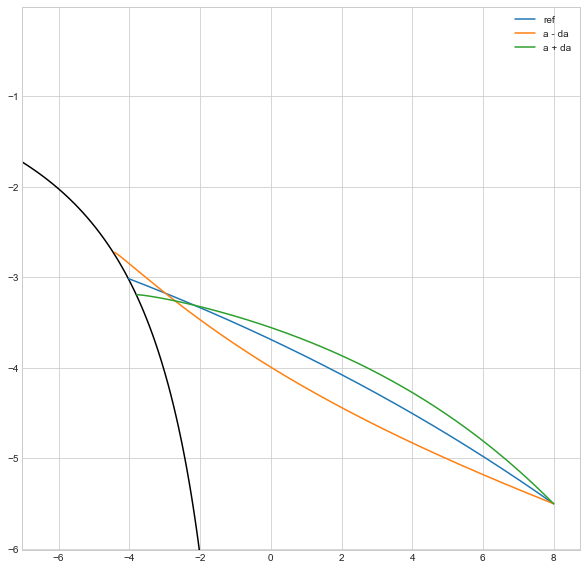

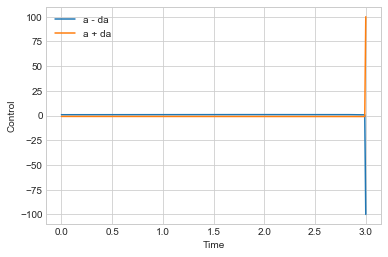

In [245]:
# Lets try just initial condition uncertainty, and just parametric uncertainty 

# Parametric Uncertainty 

plt.figure(1, figsize=(10,10))
plt.plot(x.T[0], x.T[1], label='ref')

X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,1)*3,x[-1,1] + np.linspace(-1,1)*3)
plt.contour(X, Y, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)



for delta_a, label in zip([-0.05,  0.05], ["-","+"]):
    xnew = odeint(dynamics, x0, t, args=(a+delta_a, sat_controller))
    unew = [sat_controller(ti, xi, a+delta_a) for ti,xi in zip(t,xnew)]

    plt.figure(1)
    plt.plot(xnew.T[0], xnew.T[1], label='a {} da'.format(label))
    plt.legend()

    plt.figure(2)
    plt.plot(t, unew, label='a {} da'.format(label))
    plt.xlabel('Time')
    plt.ylabel('Control')
    plt.legend()

plt.show()

Even for this toy problem with mild drag-like nonlinearity, the linearization results in poor performance unless additional gain is introduced. Of course, performance can also be enhanced by using a different monotonic variable, but this is problem dependent and not always possible. Another way we can improve performance in differentiable systems is to include second order sensitivities. 

C:\Users\cdnoyes\AppData\Local\Continuum\anaconda3\envs\edl\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


(299, 2, 200)


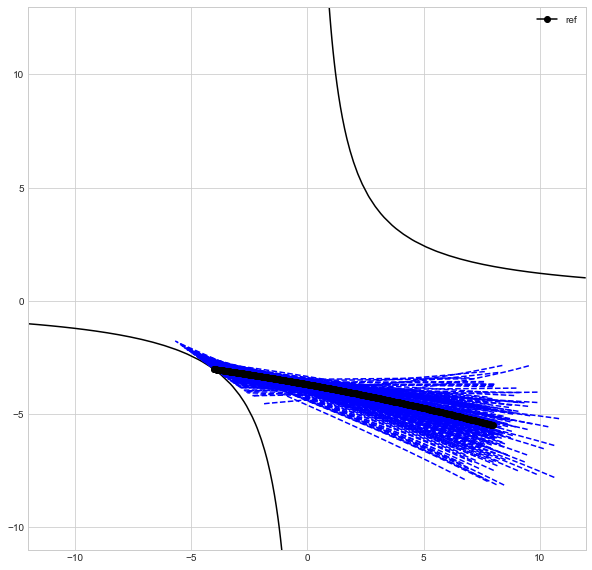

In [249]:

plt.figure(1, figsize=(10,10))


X,Y = np.meshgrid(x[-1,0] + np.linspace(-1,2)*8,x[-1,1] + np.linspace(-1,2)*8)
plt.contour(X, Y, Obj([X,Y]), [Obj(x[-1])], colors='k',alpha=1)


x0_mc = np.random.multivariate_normal(x0, np.diag([1,1]), 200).T
x_mc = RK4(dynamics, x0_mc, t, args=(a, sat_controller, np.sqrt))[:-1]
print(x_mc.shape)

for xnew in np.transpose(x_mc, (2,0,1)):
    plt.figure(1)
    plt.plot(xnew.T[0], xnew.T[1], 'b--')

#     plt.figure(2)
#     plt.plot(t, unew)
#     plt.xlabel('Time')
#     plt.ylabel('Control')
plt.plot(x.T[0], x.T[1], 'k-o', label='ref')
plt.legend()
plt.show()